# Решающие деревья

In [11]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np

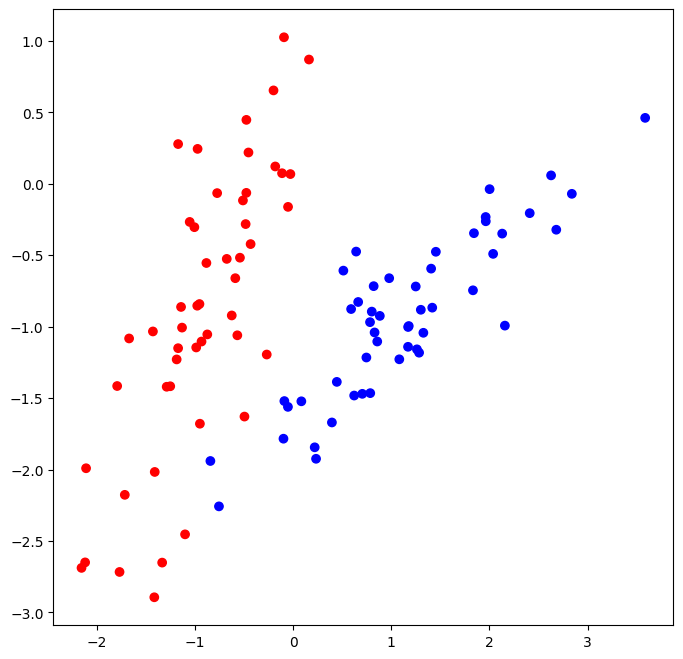

In [34]:
# сгенерируем и визуализируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors)
plt.show()

In [13]:
# Реализуем класс узла
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # пороговое значение
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [35]:
# Реализуем класс листа листа
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        classes = {}
        for label in self.labels:
            classes[label] = classes.get(label, 0) + 1
        return max(classes, key=classes.get)

In [61]:
# Расчёт критерия Джини
def gini(labels):
    _, counts_classes = np.unique(labels, return_counts = True)
    squared_probabilities = np.square(counts_classes / labels.size)
    impurity = 1 - sum(squared_probabilities)
    return impurity

In [53]:
# Расчёт качества
def quality(left_labels, right_labels, current_gini):
    p = float(len(left_labels)) / (len(left_labels) + len(right_labels))
    
    # Вычисляем качество разделения
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [71]:
# Разбиение выборки на две части
def split(data, labels, index, t):
    true_data, false_data, true_labels, false_labels = [], [], [], []
    
    for i in range(len(data)):
        if data[i][index] < t:
            true_data.append(data[i])
            true_labels.append(labels[i])
        else:
            false_data.append(data[i])
            false_labels.append(labels[i])
    
    return np.array(true_data), np.array(false_data), np.array(true_labels), np.array(false_labels)

In [55]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    # обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    best_quality = 0
    best_t = None
    best_index = None
    
    current_gini = gini(labels)
    n_features = len(data[0])
    
    # Перебираем все признаки
    for index in range(n_features):
        # Сортируем значения признака
        sorted_indices = np.argsort(data[:, index])
        sorted_data = data[sorted_indices]
        sorted_labels = labels[sorted_indices]
        
        # Перебираем все возможные пороги
        for i in range(1, len(data)):
            # Проверяем, чтобы в обоих поддеревьях было достаточно объектов
            if i < min_leaf or (len(data) - i) < min_leaf:
                continue
            
            # Берем среднее значение между соседними точками в качестве порога
            t = (sorted_data[i-1, index] + sorted_data[i, index]) / 2
            
            # Разделяем данные
            left_data, right_data, left_labels, right_labels = split(data, labels, index, t)
            
            # Вычисляем качество разделения
            q = quality(left_labels, right_labels, current_gini)
            
            # Если качество лучше, обновляем лучшие параметры
            if q > best_quality:
                best_quality = q
                best_t = t
                best_index = index
    
    return best_quality, best_t, best_index

In [99]:
# Построение дерева посредством рекурсивной функции
def build_tree(data, labels, depth=0, max_depth=10):
    # Если достигнута максимальная глубина или слишком мало объектов
    if depth >= max_depth or len(data) <= 5:
        return Leaf(data, labels)
    
    # Находим лучшее разделение
    quality, t, index = find_best_split(data, labels)
    
    # Если не удалось найти хорошее разделение
    if quality == 0:
        return Leaf(data, labels)
    
    # Разделяем данные
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим поддеревья
    true_branch = build_tree(true_data, true_labels, depth + 1, max_depth)
    false_branch = build_tree(false_data, false_labels, depth + 1, max_depth)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [73]:
# Проход объекта по дереву для его классификации
def classify_object(obj, node):
    if isinstance(node, Leaf):
        return node.prediction
    
    if obj[node.index] < node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [74]:
# Предсказание деревом для всего датасета
def predict(data, tree):
    predictions = []
    for obj in data:
        predictions.append(classify_object(obj, tree))
    return np.array(predictions)

In [91]:
# Разобьём выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size=0.3, random_state=5
)

In [100]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [101]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.09003237917176082
--> True:
  Прогноз: 0
--> False:
  Индекс 0
  Порог 0.36670855834800864
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 1


In [102]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)

In [103]:
# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [104]:
# Введём функцию подсчёта точности
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [105]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f"Train accuracy: {train_accuracy:.2f}%")

test_accuracy = accuracy_metric(test_labels, answers)
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 97.14%
Test accuracy: 86.67%


In [106]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

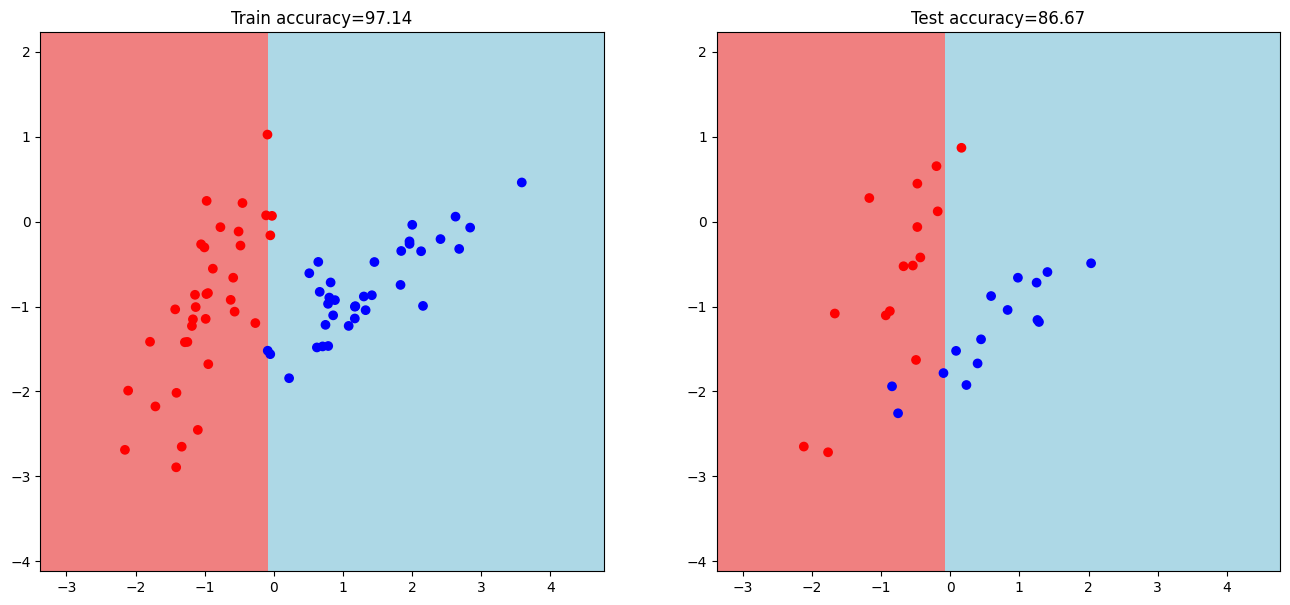

In [107]:
plt.figure(figsize=(16, 7))

# график обучающей выборки
plt.subplot(1, 2, 1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1, 2, 2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()